# Inizialize notebook content and enviorment

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [ ]:
import sys
from pathlib import Path
if IN_COLAB:
    !pip install open-clip-torch
    !pip install jaxtyping einops open-clip-torch ftfy regex timm

    !git clone https://github.com/niccobarto/token-opt-generator.git
    REPO_DIR = Path('/content/token_opt-generator')
    PERSONAL_PROJECT_DIR=Path('content/token_opt-generator/tester')
    TOKEN_OPT_DIR= REPO_DIR/"token_opt"
    sys.path.insert(0,str(TOKEN_OPT_DIR))
    sys.path.insert(0,str(REPO_DIR))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.4 MB/s eta 0:00:00
Cloning into 'token-opt-generator'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 173 (delta 39), reused 139 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (173/173), 27.97 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [ ]:
if IN_COLAB:
  !unzip "/content/inputs.zip"


Archive:  /content/inputs.zip
   creating: inputs/
   creating: inputs/add part/
   creating: inputs/add part/clean/
   creating: inputs/add part/clean/chair/
  inflating: inputs/add part/clean/chair/sedia1.jpg  
  inflating: inputs/add part/clean/chair/sedia3.jpg  
   creating: inputs/add part/clean/cup/
  inflating: inputs/add part/clean/cup/tazza1.jpg  
  inflating: inputs/add part/clean/cup/tazzaa2.jpg  
   creating: inputs/add part/clean/lamp/
  inflating: inputs/add part/clean/lamp/lampada1.jpg  
  inflating: inputs/add part/clean/lamp/lampada2.jpg  
   creating: inputs/add part/clean/sofa/
  inflating: inputs/add part/clean/sofa/divano1.jpg  
  inflating: inputs/add part/clean/sofa/divano3.jpg  
   creating: inputs/add part/clean/table/
  inflating: inputs/add part/clean/table/tavolo1.jpg  
  inflating: inputs/add part/clean/table/tavolo2.jpg  
   creating: inputs/add part/clean/vase/
  inflating: inputs/add part/clean/vase/vaso2.jpg  
  inflating: inputs/add part/clean/vase/vas

In [ ]:
BASE_DATA_DIR=Path("/content")
INPUTS_PATH=BASE_DATA_DIR/"inputs"
OUT_DIR=Path("/content/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
SCORES_FILE_PATH=OUT_DIR/"clip_score.txt"

print('BASE_DATA_DIR    =', BASE_DATA_DIR)
print('INPUTS_PATH      =', INPUTS_PATH)
print('OUT_DIR          =', OUT_DIR)
print('SCORES_FILE_PATH =', SCORES_FILE_PATH)

BASE_DATA_DIR    = /content
INPUTS_PATH      = /content/inputs
OUT_DIR          = /content/outputs
SCORES_FILE_PATH = /content/outputs/clip_score.txt


In [ ]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms.v2.functional as tvf
import gc
from einops import rearrange

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
device = torch.device("cuda")

In [ ]:
TTO_AVAILABLE=True

try:
    from tto.test_time_opt import(
    TestTimeOpt,
    TestTimeOptConfig,
    CLIPObjective,
    MultiObjective,
    SigLIPObjective
    )
    print("Token-Opt importato correttamente")
except Exception as e:
    TTO_AVAILABLE=False
    print("Errore nell'importazione di Token-Opt:", e)
print(TTO_AVAILABLE)

TESTER_AVAILABLE=True
try:
  from tester.ImageExtractor import Extractor
  import tester.ImageSaver as ImageSaver
  from tester.PromptConfigurator import PromptConfigurator
  print("Tester importato correttamente")
except Exception as e:
  TESTER_AVAILABLE=False
  print("Errore nell'importazione di Tester",e)
print(TESTER_AVAILABLE)
tto=None

Token-Opt importato correttamente
True
Tester importato correttamente
True


# Utils


## ReconstructionObjective


In [ ]:
import torch
import torch.nn as nn

class ReconstructionObjective(nn.Module):
    """
    Penalizza le differenze solo FUORI dal buco (dove mask=1).
    Dentro al buco (mask=0) non agisce.
    Compatibile con MultiObjective.
    """
    def __init__(self, masked_img: torch.Tensor, mask: torch.Tensor):
        """
        Args:
            masked_img: immagine originale mascherata (mask * img)
            mask: out-mask binaria (1 = fuori, 0 = dentro)
        """
        super().__init__()
        self.register_buffer("target", masked_img)
        self.register_buffer("mask", mask)

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        # penalizza differenze solo dove mask=1 (fuori dal buco)
        diff = (img - self.target).abs() * self.mask
        denom = self.mask.sum(dim=(1,2,3)) + 1e-8
        loss = diff.sum(dim=(1,2,3)) / denom
        return loss

In [ ]:
class ComposedCLIP(nn.Module):
    """
    CLIP sul composito: FUORI = img originale, DENTRO = img ottimizzata.
    Gradiente: 1.0 dentro, outside_grad fuori (default 0.2).
    Niente buffer registrati: orig/mask restano su CPU per non occupare VRAM.
    """
    def __init__(self, base_clip_obj: nn.Module, orig_img: torch.Tensor,
                 mask_bin: torch.Tensor, outside_grad: float = 0.2):
        super().__init__()
        self.base = base_clip_obj
        self.orig_cpu = orig_img.detach().cpu()
        self.mask_cpu = mask_bin.detach().cpu()
        self.outside_grad = float(outside_grad)  # 0..1

    def get_prompt(self):
        return self.base.prompt

    def forward(self, img_opt: torch.Tensor) -> torch.Tensor:
        device = img_opt.device
        orig = self.orig_cpu.to(device, non_blocking=True)   # [1,3,H,W]
        mask = self.mask_cpu.to(device, non_blocking=True)   # [1,1,H,W], 1=FUORI, 0=BUCO

        # composito "visivo" (quello che CLIP vede)
        composed_vis = mask * orig + (1. - mask) * img_opt

        # maschera di gradiente: pieno dentro, attenuato fuori
        grad_mask = (1. - mask) + self.outside_grad * mask  # 1 dentro, outside_grad fuori

        # stesso tensore visivo, ma con gradiente pesato (trucco detach)
        composed_for_grad = grad_mask * img_opt + (1. - grad_mask) * img_opt.detach()
        composed = composed_vis.detach() + (composed_for_grad - composed_for_grad.detach())

        return self.base(composed)


## Methods for image/tensor conversion

In [ ]:
def image_to_tensor(image:Image.Image, device=None):
  img = (1. / 255.) * torch.from_numpy(
      np.array(image).astype(np.float32)
  ).permute(2, 0, 1)
  img = tvf.resize(img, 256)
  img = tvf.center_crop(img, 256)
  img = img.unsqueeze(0)
  if device is not None:
      img = img.to(device)
  return img

def tensor_to_image(t: torch.Tensor) -> Image.Image:
    # Valori attesi in [0,1], su GPU o CPU
    t = t.detach().clamp(0, 1)

    # Se arriva [C,H,W], aggiungo la dim di batch -> [1,C,H,W]
    if t.ndim == 3:
        t = t.unsqueeze(0)
    elif t.ndim != 4:
        raise ValueError(f"tensor_to_image: tensore con {t.ndim} dimensioni non supportato")

    # [B,C,H,W] -> [H, B*W, C], uint8 su CPU
    img = Image.fromarray(
        rearrange((t * 255).to(dtype=torch.uint8, device="cpu"), "b c h w -> h (b w) c").numpy()
    )
    return img

## TokenResetter
Durante l’ottimizzazione test-time (tto(...)), il modello non genera l’immagine con un forward classico tipo diffusion, ma:


1.   parte da un insieme di token latenti (1D, compressi dal tokenizer TiTok),
2.   li ottimizza iterativamente per minimizzare una loss di obiettivo (es. CLIPObjective, ReconstructionObjective, ecc.),
3. dopo ogni step, decodifica i token per ottenere un’immagine, calcola la loss e aggiorna i token.

Il problema nasce nell’inpainting: se lasci che i token vengano ottimizzati liberamente su tutta l’immagine, anche le zone fuori dalla maschera (cioè quelle che dovrebbero restare identiche all’originale) vengono corrotte nel tempo.
Il TokenResetter serve esattamente a evitare questo

In [ ]:
class TokenResetter:
    def __init__(self, tto, masked_img, mask_bin, reset_period=4, warmup=120, alpha=0.2):
        """
        tto:          l'istanza TestTimeOpt (serve encode/decode coerenti)
        masked_img:   seed con buco (mask_bin * img)
        mask_bin:     1=FUORI, 0=BUCO (BINARIA!)
        reset_period: ogni quanti step applicare il reset
        warmup:       non resettare prima di questo step (lascia "partire" il dentro)
        alpha:        intensità del reset FUORI (0.2 = 20% verso seed, 80% resta corrente)
        """
        self.tto = tto
        self.mask = mask_bin
        self.masked_img = masked_img
        self.reset_period = reset_period
        self.warmup = warmup
        self.alpha = alpha

    @torch.no_grad()
    def __call__(self, info):
        if info.i < self.warmup or (info.i % self.reset_period) != 0:
            return
        # decodifica dai token EMA attuali
        img = self.tto.decode(info.tokens).clamp(0., 1.)
        # soft-reset FUORI: mix parziale verso il seed
        out = (1. - self.mask) * img + self.mask * (self.alpha * self.masked_img + (1 - self.alpha) * img)
        return self.tto.encode(out)

## Mask generation

In [ ]:
def generate_mask(img, x0, y0, w, h):
    N, C, H, W = img.shape
    mask = torch.ones((N, 1, H, W), device=img.device, dtype=img.dtype)
    x1 = max(0, min(W, x0 + w))
    y1 = max(0, min(H, y0 + h))
    x0 = max(0, min(W, x0))
    y0 = max(0, min(H, y0))
    if x1 > x0 and y1 > y0:
        mask[..., y0:y1, x0:x1] = 0.0
    return mask

## CUDA Cleaner

In [ ]:
def hard_clear_cuda(names=()):
    import gc, torch
    g = globals()
    for n in list(names):
        if n in g:
            try: del g[n]
            except: pass
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()


## Inpainting plotter

In [ ]:
class InpaintingPlotter:
    def __init__(self, masked_img, mask):
        self.masked_img = masked_img
        self.mask = mask

    def __call__(self, info):
        if info.i % 50 == 0:
            print(f"i = {info.i}, CLIP loss={info.loss}")
            img = tto.decode(info.tokens).clamp(0., 1.)
            img_blended = (1. - self.mask) * img + self.masked_img
            display(tensor_to_image(*img_blended))
            display(tensor_to_image(img))

# Main part

##Define TestTimeOptConfig and MultiObjectives

### Load image and create masked image and mask

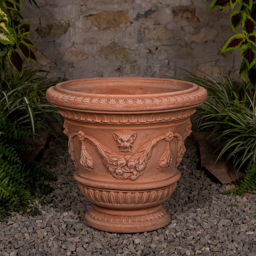

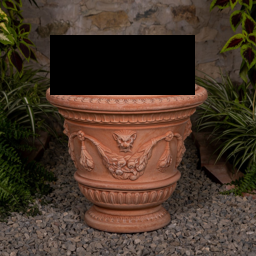

In [ ]:
# 1) immagine alla risoluzione del tokenizer (es. 256x256)
FILE_PATH=Path("change_structure/vase/vaso1.jpg")
image = Image.open(INPUTS_PATH/FILE_PATH).convert("RGB").resize((256,256), Image.BICUBIC)
#image = Image.open(INPUTS_PATH/"quadro.jpg").convert("RGB").resize((256,256), Image.BICUBIC)
img   = image_to_tensor(image, device)                   # [1,3,256,256]

# 2) maschera binaria (1 fuori / 0 dentro)
mask  = generate_mask(img, x0=50, y0=35, w=145, h=60)  # [1,1,256,256]
mask_bin = (mask > 0.5).float()

masked_img = mask_bin * img

mask_gaussian = tvf.gaussian_blur(mask, 21)
# 3) immagine mascherata


display(tensor_to_image(img))
display(tensor_to_image(masked_img))

### Define Objectives and TestTimeOptConfiguration

In [ ]:
hard_clear_cuda(("tto","objective","clip_base","clip_objective","reconstruction_objective"))

prompt="a photo of a vase with a lot of blue flowers on it"
clip_num_augs = 8
clip_cfg =2.5
multi_objective_weights = [2,3]
#multi_objective_weights = [1]

tto_config = TestTimeOptConfig(
    num_iter=351,          # resta < ~580 con LR=0.1
    ema_decay=0.98,       # smoothing anti-lavatrice
    lr=1e-1,
    enable_amp=True,
    reg_type="seed",
    reg_weight=0.05,       # ancoraggio extra al seed FUORI
    token_noise=2e-4,
    vae_deterministic_sampling=True
)

clip_objective = CLIPObjective(num_augmentations=clip_num_augs, cfg_scale=clip_cfg, prompt=prompt)

# wrapper SENZA buffer registrati
#clip_objective = ComposedCLIP(clip_base, img, mask_bin,0.0)
reconstruction_objective = ReconstructionObjective(masked_img, mask_bin)

objective = MultiObjective(
                          #[clip_objective],
                          [clip_objective, reconstruction_objective],
                           multi_objective_weights)

# ora crea TTO
tto = TestTimeOpt(tto_config, objective).to(device)

## Loop principale

input


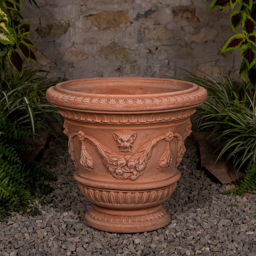

TestTimeOptConfiguration
TestTimeOptConfig(titok_checkpoint='yucornetto/tokenizer_titok_l32_imagenet', optimize_post_quantization_tokens=False, vae_deterministic_sampling=True, lr=0.1, ema_decay=0.98, token_noise=0.0002, reg_weight=0.05, reg_type='seed', num_iter=351, enable_amp=True)

Prompt
a photo of a vase with a lot of blue flowers on it
i = 0, CLIP loss=tensor([0.6843], device='cuda:0', grad_fn=<AddBackward0>)


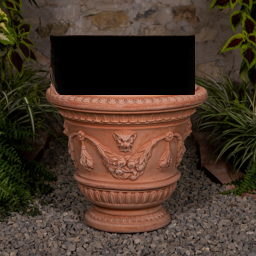

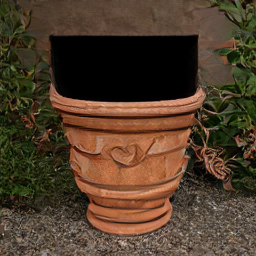

i = 50, CLIP loss=tensor([0.2430], device='cuda:0', grad_fn=<AddBackward0>)


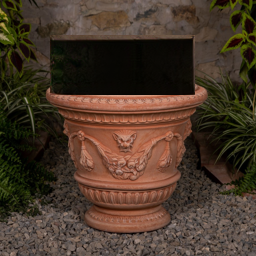

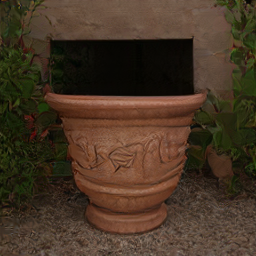

i = 100, CLIP loss=tensor([0.2164], device='cuda:0', grad_fn=<AddBackward0>)


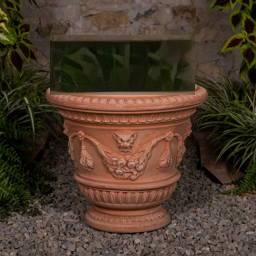

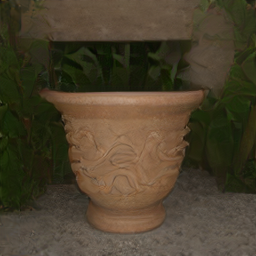

i = 150, CLIP loss=tensor([0.1168], device='cuda:0', grad_fn=<AddBackward0>)


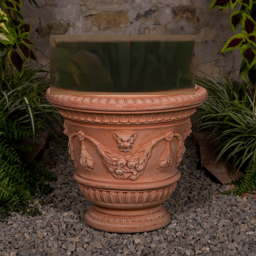

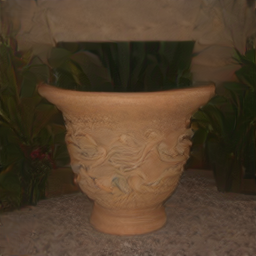

i = 200, CLIP loss=tensor([0.0993], device='cuda:0', grad_fn=<AddBackward0>)


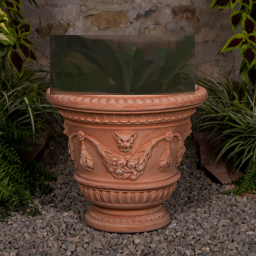

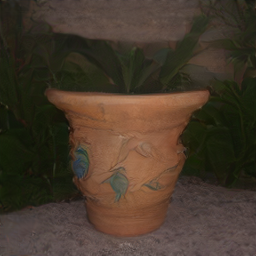

i = 250, CLIP loss=tensor([0.0191], device='cuda:0', grad_fn=<AddBackward0>)


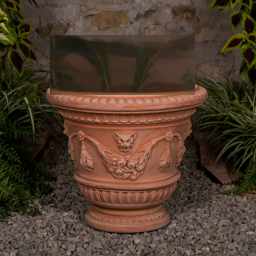

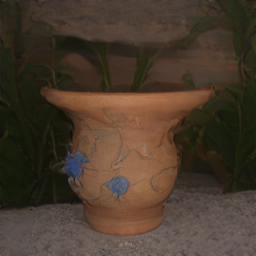

i = 300, CLIP loss=tensor([-0.0041], device='cuda:0', grad_fn=<AddBackward0>)


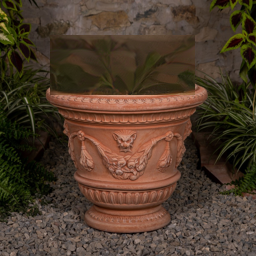

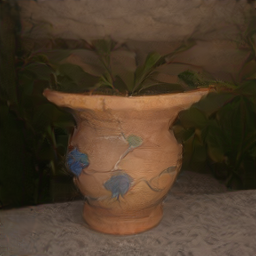

i = 350, CLIP loss=tensor([-0.0312], device='cuda:0', grad_fn=<AddBackward0>)


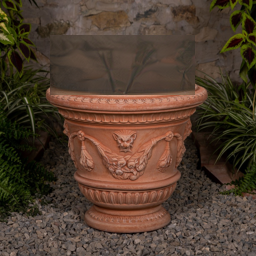

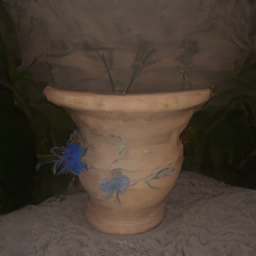

In [ ]:
print("input")
display(tensor_to_image(img))

print("TestTimeOptConfiguration")
print(tto.config)
print("")
print("Prompt")
print(tto.objective.objectives[0].prompt)

img_opt,loss = tto(
    seed=masked_img,
    callback=InpaintingPlotter(masked_img, mask_bin),
    #token_reset_callback=TokenResetter(tto, masked_img, mask, reset_period=10, warmup=0, alpha=0.2)
    )

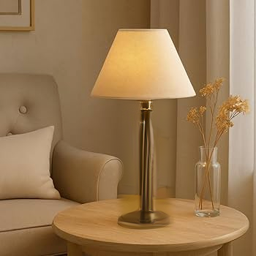

In [ ]:
final_img=tensor_to_image(img_opt*(1-mask_gaussian)+img*(mask_gaussian))
display(final_img)

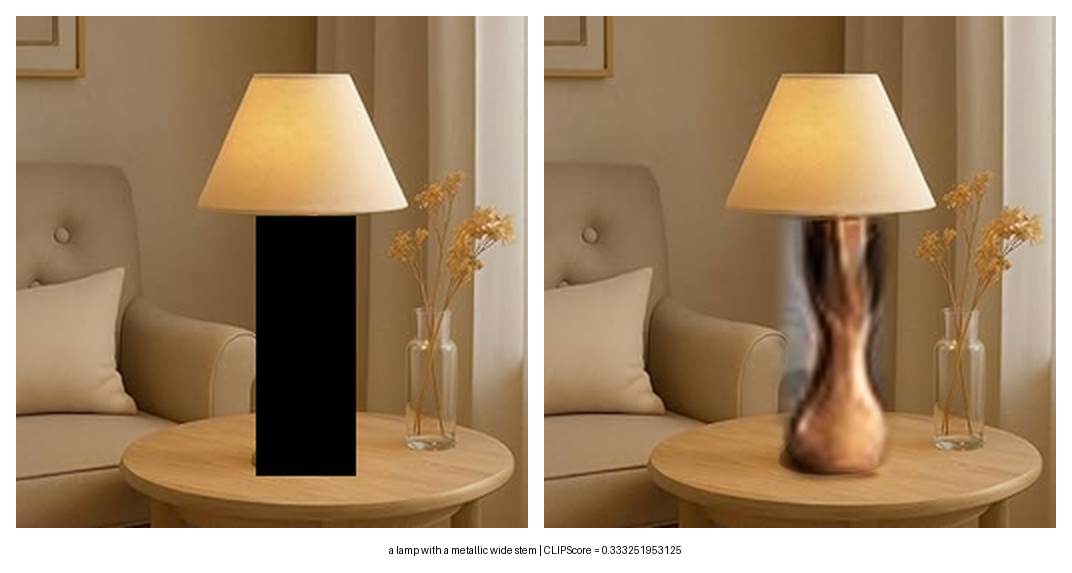

In [ ]:
ImageSaver.create_side_by_side_with_caption(tensor_to_image(masked_img),
                                            final_img,
                                            prompt,
                                            (-loss.detach().mean()).item(),
                                            OUT_DIR/FILE_PATH)

In [ ]:
#!zip -r outputs /content/outputs